In [107]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import math
import pickle
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

In [108]:
file_path = '/content/drive/MyDrive/Data Science Student Material/Project 3 - Cohort 4/Data/Project_3_Movie_Data.csv'
movies = pd.read_csv(file_path)

In [109]:
# Supporting functions
def extract_json(json_str, key, num=0):
    """Pass json string, 'key', optional number_of_elements to return (0==all).  Returns |-separated string of values"""
    if num == 0:
        num = len(json.loads(json_str))
    else:
        num = min(num, len(json.loads(json_str)))
    data_dict = json.loads(json_str)
    return '|'.join([data_dict[i][key] for i in range(num)])

def rmspe(y_true, y_pred):
    rmspe_val = np.sqrt(np.mean(np.square((y_true-y_pred)/y_true)))
    return rmspe_val

def root_mean_squared_percentage_error(y_true, y_predicted, y_shift):
    rmspe = np.sqrt(np.mean(np.square((y_true - y_predicted)/(y_true + y_shift))))*100
    return rmspe

def root_mean_squared_error(y_true, y_predicted):
    rmse = np.sqrt(np.mean(np.square(y_true - y_predicted)))*100
    return rmse

In [110]:
movies.shape

(4322, 24)

In [111]:
movies.head(3)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,movie_id,title.1,cast,crew,revenue
0,0,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 10749, ""n...",NaN,44770,"[{""id"": 10183, ""name"": ""independent film""}]",en,The Exploding Girl,"On a summer break from college, Ivy, a young e...",0.611081,[],[],2009-04-22,80.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,NaN,The Exploding Girl,6.4,15,44770,The Exploding Girl,"[{""cast_id"": 3, ""character"": ""Ivy"", ""credit_id...","[{""credit_id"": ""52fe469bc3a36847f8108245"", ""de...",0
1,1500000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 27, ""nam...",http://www.dhentertainment.com/projects/1.my-n...,1961,"[{""id"": 9755, ""name"": ""parody""}, {""id"": 33465,...",en,My Name Is Bruce,B Movie Legend Bruce Campbell is mistaken for ...,7.559100,"[{""name"": ""Dark Horse Entertainment"", ""id"": 55...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-10-01,86.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Fearless! Unstoppable! Ready For His Close-Up!,My Name Is Bruce,5.9,107,1961,My Name Is Bruce,"[{""cast_id"": 2, ""character"": ""Bruce Campbell"",...","[{""credit_id"": ""52fe4326c3a36847f803e1bf"", ""de...",173066
2,25000000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...",http://whatjusthappenedfilm.com/,8944,"[{""id"": 887, ""name"": ""film producer""}, {""id"": ...",en,What Just Happened,During the course of an ordinary week in Holly...,8.316530,"[{""name"": ""2929 Productions"", ""id"": 846}, {""na...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2008-10-17,104.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,Admit nothing.,What Just Happened,5.2,127,8944,What Just Happened,"[{""cast_id"": 2, ""character"": ""Himself"", ""credi...","[{""credit_id"": ""56fa7d06c3a3681937002bd9"", ""de...",6673422


## Data Cleaning

In [112]:
movies_clean = movies.copy()

In [113]:
# Drop columns that don't provide useful information: tagline, title, movie_id, title.1, overview, original_title, id, homepage
# ?Drop 'status' != Released before column drop?
movies_clean.drop(columns=['tagline', 'title', 'movie_id', 'title.1', 'overview', 'original_title', 'id', 'homepage'], inplace=True)
movies_clean.head(1)

,budget,genres,keywords,original_language,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,status,vote_average,vote_count,cast,crew,revenue
0,0,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 10749, ""n...","[{""id"": 10183, ""name"": ""independent film""}]",en,0.611081,[],[],2009-04-22,80.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,6.4,15,"[{""cast_id"": 3, ""character"": ""Ivy"", ""credit_id...","[{""credit_id"": ""52fe469bc3a36847f8108245"", ""de...",0


In [114]:
# Look at Zero-budget/Zero-revenue movies
sum((movies_clean['budget']==0).apply(int) & (movies_clean['revenue']==0).apply(int))

799

In [115]:
# Drop observations with zero budget, less than $1000 revenue
movies_clean = movies_clean[movies_clean['budget']>0]
movies_clean = movies_clean[movies_clean['revenue']>1000]
movies_clean = movies_clean.reset_index(drop=True)

In [116]:
# Clean up genres column/remove empty's
print(movies_clean.shape)
print(movies_clean['genres'][movies_clean['genres'].apply(len)<3].count())
movies_clean = movies_clean[movies_clean['genres'].apply(len)>2]
print(movies_clean.shape)

(2897, 16)
1
(2896, 16)


In [117]:
# Clean up 'production_companies' column.  35 empty crew observation
print(movies_clean.shape)
print(movies_clean['production_companies'][movies_clean['production_companies'].apply(len)<3].count())
movies_clean = movies_clean[movies_clean['production_companies'].apply(len)>2]
print(movies_clean.shape)

(2896, 16)
35
(2861, 16)


In [118]:
# Clean up 'cast' column.  1 empty cast observations
print(movies_clean.shape)
print(movies_clean['cast'][movies_clean['cast'].apply(len)<3].count())
movies_clean = movies_clean[movies_clean['cast'].apply(len)>2]
print(movies_clean.shape)

(2861, 16)
1
(2860, 16)


In [119]:
# Clean up 'crew' column.  1 empty crew observation
print(movies_clean.shape)
print(movies_clean['crew'][movies_clean['crew'].apply(len)<3].count())
movies_clean = movies_clean[movies_clean['crew'].apply(len)>2]
print(movies_clean.shape)

(2860, 16)
1
(2859, 16)


In [120]:
# Clean up 'release_date' column.
print(movies_clean.shape)
print(movies_clean['release_date'][movies_clean['release_date'].apply(len)<3].count())
movies_clean = movies_clean[movies_clean['release_date'].apply(len)>1]
print(movies_clean.shape)

#movies_clean['release_date'] = movies_clean['release_date'].astype(int)

(2859, 16)
0
(2859, 16)


In [121]:
movies_clean = movies_clean.reset_index(drop=True)

In [122]:
# One-hot encode genres
#movies_clean['genre_names'] = movies_clean['genres'].apply(lambda s: '|'.join([e['name'] for e in json.loads(s)]))
#genre_one_hot = movies_clean['genre_names'].str.get_dummies('|')
#movies_clean_one_hot = pd.concat([movies_clean, genre_one_hot], axis=1)
movies_clean_one_hot = movies_clean.copy()
movies_clean_one_hot.head(2)

,budget,genres,keywords,original_language,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,status,vote_average,vote_count,cast,crew,revenue
0,1500000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 27, ""nam...","[{""id"": 9755, ""name"": ""parody""}, {""id"": 33465,...",en,7.55910,"[{""name"": ""Dark Horse Entertainment"", ""id"": 55...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-10-01,86.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,5.9,107,"[{""cast_id"": 2, ""character"": ""Bruce Campbell"",...","[{""credit_id"": ""52fe4326c3a36847f803e1bf"", ""de...",173066
1,25000000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...","[{""id"": 887, ""name"": ""film producer""}, {""id"": ...",en,8.31653,"[{""name"": ""2929 Productions"", ""id"": 846}, {""na...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2008-10-17,104.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,5.2,127,"[{""cast_id"": 2, ""character"": ""Himself"", ""credi...","[{""credit_id"": ""56fa7d06c3a3681937002bd9"", ""de...",6673422


In [123]:
# Pull out all production_companies
production_companies_df = pd.DataFrame(columns=['production_companies'])
for row in movies_clean_one_hot.iterrows():
    for i in range(len(json.loads(row[1][5]))):   # row[1][5] is production_countries string
        production_companies_df = pd.concat([production_companies_df, pd.DataFrame([{'production_companies':json.loads(row[1][5])[i]['name']}])], ignore_index=True)

In [124]:
print(production_companies_df.shape)
production_companies_df.value_counts()

(9217, 1)


production_companies                  
Universal Pictures                        250
Warner Bros.                              249
Paramount Pictures                        218
Twentieth Century Fox Film Corporation    181
Columbia Pictures                         146
                                         ... 
Neufeld Rehme Productions                   1
Neo Art & Logic                             1
Nelson Entertainment                        1
Nederlandse Programma Stichting (NPS)       1
"DIA" Productions GmbH & Co. KG             1
Length: 3290, dtype: int64

In [125]:
# Create dataframe from production_companies_df.value_counts()
production_companies_counts_df = pd.concat([production_companies_df.value_counts().index.get_level_values(0).to_frame(index=False), pd.DataFrame(production_companies_df.value_counts().values, columns=['count'])], axis=1)

In [126]:
# Create production_companies rank summation
comp_counts = movies_clean_one_hot['production_companies'].apply(lambda s: sum([int(production_companies_counts_df[production_companies_counts_df['production_companies']==comp['name']]['count']) for comp in json.loads(s)]))
comp_counts.rename('production_rank', inplace=True)
movies_clean_one_hot = pd.concat([movies_clean_one_hot, comp_counts], axis=1)
#movies_clean_one_hot.drop(['production_companies', 'production_companies_names'], axis=1, inplace=True)
movies_clean_one_hot.head(2)

,budget,genres,keywords,original_language,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,status,vote_average,vote_count,cast,crew,revenue,production_rank
0,1500000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 27, ""nam...","[{""id"": 9755, ""name"": ""parody""}, {""id"": 33465,...",en,7.55910,"[{""name"": ""Dark Horse Entertainment"", ""id"": 55...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-10-01,86.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,5.9,107,"[{""cast_id"": 2, ""character"": ""Bruce Campbell"",...","[{""credit_id"": ""52fe4326c3a36847f803e1bf"", ""de...",173066,11
1,25000000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...","[{""id"": 887, ""name"": ""film producer""}, {""id"": ...",en,8.31653,"[{""name"": ""2929 Productions"", ""id"": 846}, {""na...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2008-10-17,104.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,5.2,127,"[{""cast_id"": 2, ""character"": ""Himself"", ""credi...","[{""credit_id"": ""56fa7d06c3a3681937002bd9"", ""de...",6673422,24


In [127]:
movies_clean_one_hot.shape

(2859, 17)

In [128]:
# Create dataframe from .value_counts()
#cast_counts_df = pd.concat([cast_df.value_counts().index.get_level_values(0).to_frame(index=False), pd.DataFrame(cast_df.value_counts().values, columns=['count'])], axis=1)

In [129]:
#cast_counts_df

In [130]:
"""
cast_revenue_df = pd.DataFrame(columns=['name', 'revenue'])

for row in movies_clean_one_hot.iterrows():
    for i in range(len(json.loads(row[1][13]))):   # row[1][21] is cast string in ORIGINAL dataset
        cast_revenue_df = pd.concat([cast_revenue_df, pd.DataFrame([{'name':json.loads(row[1][13])[i]['name'], 'revenue':row[1][15]*math.exp(-0.4*i)}])], ignore_index=True)

cast_revenue_df.to_csv('/content/drive/MyDrive/Colab Notebooks/cast_revenue_budget.csv', index=False)
"""
cast_revenue_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/cast_revenue_budget.csv')

In [131]:
cast_revenue_df_unique = pd.unique(cast_revenue_df['name'])

In [132]:
cast_revenue_df_unique

array(['Bruce Campbell', 'Grace Thorsen', 'Ted Raimi', ...,
       'Katelynn Tilley', 'Catherine Natale', 'Blair Redford'],
      dtype=object)

In [133]:
"""
cast_cumm_revenue = pd.DataFrame(columns=['name', 'cumm_revenue'])

for name in cast_revenue_df_unique:
    cast_cumm_revenue = cast_cumm_revenue.append({'name': name, 'cumm_revenue': sum([row[1][1] for row in cast_revenue_df[cast_revenue_df['name'] == name].iterrows()])}, ignore_index=True)

#cast_cumm_revenue = cast_cumm_revenue.sort_values(by='cumm_revenue', ascending=False)
"""

"\ncast_cumm_revenue = pd.DataFrame(columns=['name', 'cumm_revenue'])\n\nfor name in cast_revenue_df_unique:\n    cast_cumm_revenue = cast_cumm_revenue.append({'name': name, 'cumm_revenue': sum([row[1][1] for row in cast_revenue_df[cast_revenue_df['name'] == name].iterrows()])}, ignore_index=True)\n\n#cast_cumm_revenue = cast_cumm_revenue.sort_values(by='cumm_revenue', ascending=False)\n"

In [134]:
#cast_cumm_revenue.to_csv('/content/drive/MyDrive/Colab Notebooks/cast_cumm_revenue_budget.csv', index=False)
cast_cumm_revenue = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/cast_cumm_revenue_budget.csv')

In [135]:
# Concat a 'cast_worth' column to movies, which comprises a weighted-sum of all cast member's cummulative worth
"""
cast_worth = pd.DataFrame(columns=['cast_worth'])
for row in movies_clean_one_hot.iterrows():
    cast_worth = pd.concat([cast_worth, pd.DataFrame({'cast_worth': sum([int(cast_cumm_revenue[cast_cumm_revenue['name']==e['name']]['cumm_revenue'])*math.exp(-0.4*i) for i,e in enumerate(json.loads(row[1][13]))])}, index=[0])], ignore_index=True)
"""

"\ncast_worth = pd.DataFrame(columns=['cast_worth'])\nfor row in movies_clean_one_hot.iterrows():\n    cast_worth = pd.concat([cast_worth, pd.DataFrame({'cast_worth': sum([int(cast_cumm_revenue[cast_cumm_revenue['name']==e['name']]['cumm_revenue'])*math.exp(-0.4*i) for i,e in enumerate(json.loads(row[1][13]))])}, index=[0])], ignore_index=True)\n"

In [136]:
#cast_worth.to_csv('/content/drive/MyDrive/Colab Notebooks/cast_worth.csv', index=False)
cast_worth = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/cast_worth.csv')

In [137]:
movies_clean_one_hot['cast_worth'] = cast_worth

In [138]:
# Add director column
"""
director = []
for row in movies_clean.iterrows():
    for e in json.loads(row[1][14]):
        if e['job']=='Director':
            director.append(e['name'])
            break
"""

"\ndirector = []\nfor row in movies_clean.iterrows():\n    for e in json.loads(row[1][14]):\n        if e['job']=='Director':\n            director.append(e['name'])\n            break\n"

In [139]:
#movies_clean_one_hot = pd.concat([movies_clean_one_hot, pd.DataFrame(director, columns=['director'])], axis=1)

In [140]:
movies_clean_one_hot['release_date'] = movies_clean_one_hot['release_date'].str.slice(start=5, stop=7).apply(int)
#movies_clean['release_date'] = movies_clean['release_date'].astype(int)

In [141]:
movies_clean_one_hot.head()

,budget,genres,keywords,original_language,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,status,vote_average,vote_count,cast,crew,revenue,production_rank,cast_worth
0,1500000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 27, ""nam...","[{""id"": 9755, ""name"": ""parody""}, {""id"": 33465,...",en,7.559100,"[{""name"": ""Dark Horse Entertainment"", ""id"": 55...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",10,86.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,5.9,107,"[{""cast_id"": 2, ""character"": ""Bruce Campbell"",...","[{""credit_id"": ""52fe4326c3a36847f803e1bf"", ""de...",173066,11,1.423051e+08
1,25000000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...","[{""id"": 887, ""name"": ""film producer""}, {""id"": ...",en,8.316530,"[{""name"": ""2929 Productions"", ""id"": 846}, {""na...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",10,104.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,5.2,127,"[{""cast_id"": 2, ""character"": ""Himself"", ""credi...","[{""credit_id"": ""56fa7d06c3a3681937002bd9"", ""de...",6673422,24,7.610422e+09
2,140000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 53, ""nam...","[{""id"": 83, ""name"": ""saving the world""}, {""id""...",en,58.485967,"[{""name"": ""Jerry Bruckheimer Films"", ""id"": 130...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",7,151.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,6.4,2482,"[{""cast_id"": 7, ""character"": ""Harry S. Stamper...","[{""credit_id"": ""5491a0a4c3a368466b001ce7"", ""de...",553799566,108,6.953074e+09
3,70000000,"[{""id"": 27, ""name"": ""Horror""}, {""id"": 28, ""nam...","[{""id"": 3133, ""name"": ""vampire""}, {""id"": 3633,...",en,64.457947,"[{""name"": ""Universal Pictures"", ""id"": 33}, {""n...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",10,92.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,6.2,2389,"[{""cast_id"": 6, ""character"": ""Dracula / Vlad T...","[{""credit_id"": ""545e6edf0e0a261fb300708a"", ""de...",215529201,307,7.620041e+08
4,10500000,"[{""id"": 878, ""name"": ""Science Fiction""}, {""id""...","[{""id"": 305, ""name"": ""moon""}, {""id"": 306, ""nam...",en,86.201184,"[{""name"": ""Stanley Kubrick Productions"", ""id"":...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",4,149.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,7.9,2998,"[{""cast_id"": 6, ""character"": ""Dr. Dave Bowman""...","[{""credit_id"": ""52fe4212c3a36847f8001a05"", ""de...",68700000,80,1.255667e+08


## Exploratory Data Analysis

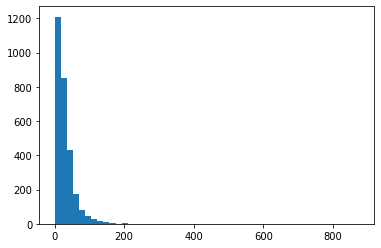

In [142]:
# Popularity histogram
plt.hist(movies_clean_one_hot['popularity'], bins=50);

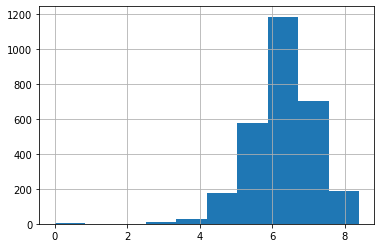

In [143]:
movies_clean_one_hot['vote_average'].hist();

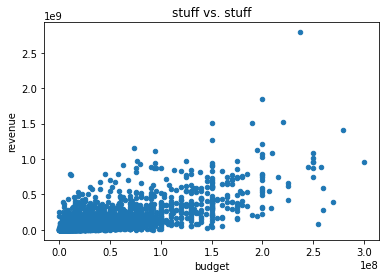

In [144]:
movies_clean_one_hot.plot(kind='scatter', x='budget', y='revenue', title='stuff vs. stuff');

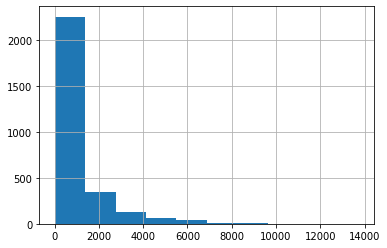

In [145]:
# vote_count
movies_clean_one_hot['vote_count'].hist();

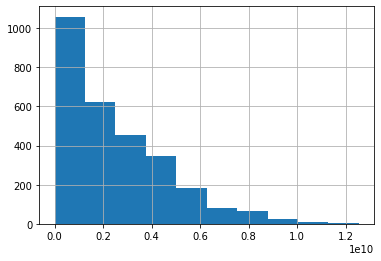

In [146]:
movies_clean_one_hot['cast_worth'].hist();

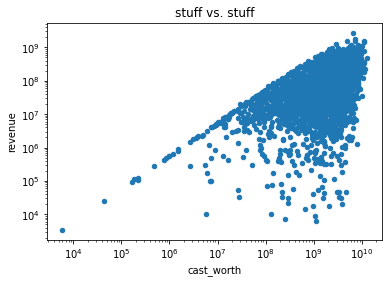

In [147]:
movies_clean_one_hot.plot(kind='scatter', loglog=True, x='cast_worth', y='revenue', title='stuff vs. stuff');

In [148]:
movies_clean_one_hot.corr()['revenue']

budget             0.692080
popularity         0.591160
release_date       0.041604
runtime            0.228287
vote_average       0.197997
vote_count         0.757363
revenue            1.000000
production_rank    0.236240
cast_worth         0.488982
Name: revenue, dtype: float64

## Data Processing

In [149]:
y = movies_clean_one_hot['revenue']
X = movies_clean_one_hot.drop('revenue', axis=1).copy()
#X.drop(['genres','keywords','status','original_language','production_companies','production_countries','spoken_languages','cast','crew','genre_names'], axis=1, inplace=True)
X.drop(['genres','keywords','status','original_language','production_companies','production_countries','spoken_languages','cast','crew'], axis=1, inplace=True)

In [150]:
X.head()

,budget,popularity,release_date,runtime,vote_average,vote_count,production_rank,cast_worth
0,1500000,7.559100,10,86.0,5.9,107,11,1.423051e+08
1,25000000,8.316530,10,104.0,5.2,127,24,7.610422e+09
2,140000000,58.485967,7,151.0,6.4,2482,108,6.953074e+09
3,70000000,64.457947,10,92.0,6.2,2389,307,7.620041e+08
4,10500000,86.201184,4,149.0,7.9,2998,80,1.255667e+08


## Decision Trees

In [151]:
numLoops = 100
depth_vec = np.arange(1,11)
depth_error = np.zeros(len(depth_vec))

for outIdx in range(0,len(depth_error)):
  mean_error = np.zeros(numLoops)
  depth_val  = outIdx + 1
  model = DecisionTreeRegressor(max_depth=depth_val)
  for idx in range(0,numLoops):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mean_error[idx] = rmspe(y_test, y_pred)

  depth_error[outIdx] = np.mean(mean_error)

depth_error

array([562.95884559, 390.38083558, 226.87392808, 142.86925562,
       106.29407288,  88.72764387, 103.59076674,  92.14527009,
        91.36592978,  85.41566324])

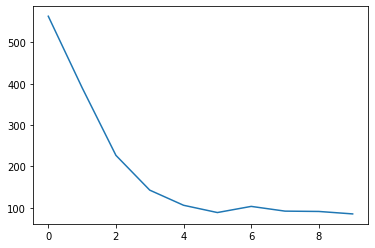

In [152]:
plt.plot(depth_error);

### Decision Tree Graph

In [153]:
model = DecisionTreeRegressor(max_depth=3, criterion='mae')
model.fit(X,y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

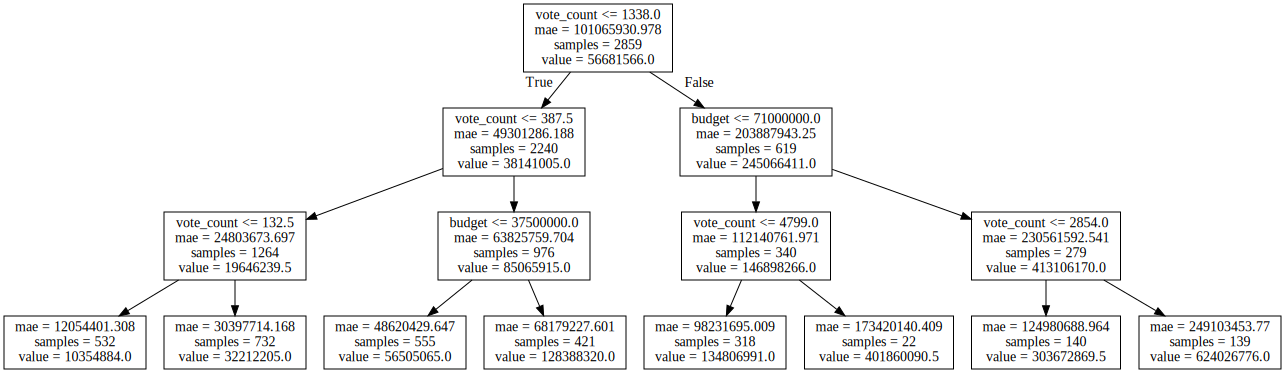

In [154]:
import graphviz
import pydotplus
from IPython.display import display
from sklearn import tree

display(graphviz.Source(tree.export_graphviz(model, feature_names=X.columns)));

### Random Forest

[620.58320017 635.17325615 561.55904365 560.66516669 599.25409158
 549.82133987 620.98341717 553.41249321 576.21220601 607.00702501
 569.58732482 591.78915279 580.93628101 589.78547018 571.59883378
 586.24518045 578.6423132  556.44891043 567.65653475 551.95085959]


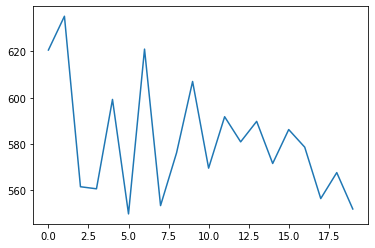

In [155]:
numTrees = 20

rmse_all = np.zeros(numTrees)

for outIdx in range(0,numTrees):

  numLoops = 20
  rmse_inside = np.zeros(numLoops)

  for inIdx in range(0,numLoops):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    rfModel = RandomForestRegressor(n_estimators = (outIdx+1), max_depth=4)
    rfModel.fit(X_train, y_train)
    y_pred_rf = rfModel.predict(X_test)
    rmse_inside[inIdx] = root_mean_squared_percentage_error(y_test, y_pred_rf, 1e6)

  #print(outIdx,' trees finished.')
  rmse_all[outIdx] = np.mean(rmse_inside)

print(rmse_all)

plt.plot(rmse_all);

### XGBoost

In [156]:
numLoops = 100
mse_xgb = np.zeros(numLoops)

for idx in range(0,numLoops):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
  xgbr = xgb.XGBRegressor(objective = 'reg:squarederror')
  xgbr.fit(X_train, np.log10(y_train))
  y_pred_xgb = xgbr.predict(X_test)
  mse_xgb[idx] = root_mean_squared_percentage_error(y_test, 10**y_pred_xgb, 1e6)

mse_xgb.mean()

223.2860413328187

In [157]:
np.sqrt(mse_xgb.mean())

14.942758826027365

(-1000.0, 1000.0)

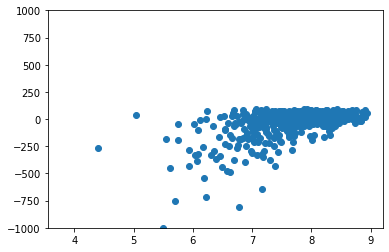

In [158]:
plt.scatter(np.log10(y_test),((y_test - 10**y_pred_xgb)/(y_test))*100)
plt.ylim([-1000, 1000])
#plt.xlim([0,1e9])

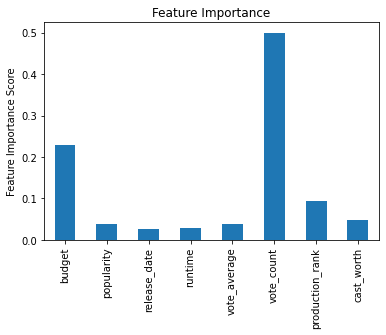

In [159]:
feat_imp = pd.Series(xgbr.feature_importances_, index=X.columns)
feat_imp.plot(kind='bar', title='Feature Importance')
plt.ylabel('Feature Importance Score');

In [160]:
print('Done')

Done
